In [1]:
import pandas as pd
from sqlalchemy import create_engine
import os 
from dotenv import load_dotenv

In [2]:
# Load environment variables
dotenv_path = os.path.join(os.path.dirname(os.getcwd()), 'config', '.env')
load_dotenv(dotenv_path=dotenv_path)

engine = create_engine(f"postgresql://{os.getenv('DB_USER')}:{os.getenv('DB_PASSWORD')}@{os.getenv('DB_HOST')}:{os.getenv('DB_PORT')}/{os.getenv('DB_NAME')}")


In [4]:
data = pd.read_sql("SELECT * FROM region_behaviour_matrix", engine)
data.head()

,year,region,num_completed_orders,unique_customers,total_sales,total_profit,avg_order_value,avg_discount_percentage,num_loss_cases,total_value_lost,avg_discount_on_losses,units_lost
0,2019.0,Asia,53,53,60175.455804,50148.818335,1135.385959,15.304340,787,8.951801e+05,15.526023,4266.0
1,2019.0,Australia,36,36,44746.323801,37853.019047,1242.953439,16.184444,722,8.494640e+05,14.902812,3901.0
2,2019.0,Europe,40,40,40430.644459,32745.938996,1010.766111,15.928000,756,8.855301e+05,14.524947,4190.0
3,2019.0,North America,34,34,39506.211358,32992.677385,1161.947393,12.966471,713,8.111198e+05,14.365947,3808.0
4,2019.0,South America,35,35,52051.357327,44564.314769,1487.181638,13.062000,790,1.016922e+06,14.870076,4569.0


In [5]:
#Feature Engineering

df = data.copy()


# Base rates/ metrics
df['loss_rate'] = df['num_loss_cases'] / (df['num_loss_cases'] + df['num_completed_orders'])
df['discount_rate'] = df['avg_discount_percentage'] / 100
df['profit_margin'] = df['total_profit'] / df['total_sales']
df['avg_profit_per_order'] = df['total_profit'] / df['num_completed_orders']



In [6]:
# Modeling
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

# Features and target
features = ['discount_rate', 'avg_order_value', 'num_completed_orders', 'loss_rate']
target = 'avg_profit_per_order'

X = df[features]
y = df[target]

# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

#Split and train the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("R² Score:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))



R² Score: 0.9975973544075608
MSE: 49.04304797118875


In [7]:
# What If setup
# Create simulation scenarios
# What-if Simulations
discount_shocks = [-0.05, 0.00, 0.05]  # 5% decrease, no change, 5% increase
results = []

for shock in discount_shocks:
    temp_df = df.copy()
    temp_df['discount_rate'] = temp_df['discount_rate'] + shock
    temp_df['discount_rate'] = temp_df['discount_rate'].clip(0, 1)
    
    X_sim = temp_df[features]
    X_sim_scaled = scaler.transform(X_sim)
    temp_df['predicted_profit'] = model.predict(X_sim_scaled)
    temp_df['scenario'] = f"{int(shock * 100)}% Discount"
    
    results.append(temp_df[['region', 'scenario', 'predicted_profit']])

# Combine results
results_df = pd.concat(results)
results_df.reset_index(drop=True, inplace=True)

# Save results to database
results_df.to_sql('discount_simulation_results', engine, if_exists='replace', index=False)

90

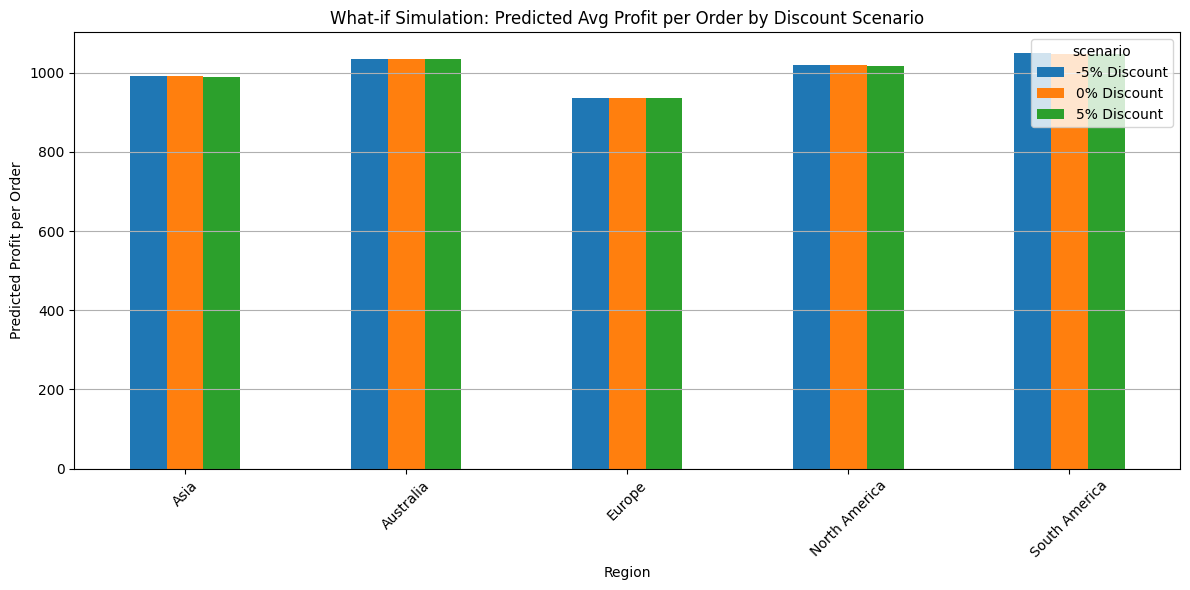

In [45]:
import matplotlib.pyplot as plt

pivot = results_df.pivot_table(
    index='region',
    columns='scenario',
    values='predicted_profit',
    aggfunc='mean' 
)

# Plot
pivot.plot(kind='bar', figsize=(12, 6))
plt.title('What-if Simulation: Predicted Avg Profit per Order by Discount Scenario')
plt.ylabel('Predicted Profit per Order')
plt.xlabel('Region')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()

plt.show()

In [8]:
# What-if Simulation Using avg_order_value
# Create simulation scenarios
# Define % changes
value_scenarios = {
    '-10% Value': 0.9,
    '0% Change': 1.0,
    '+10% Value': 1.1
}

what_if_results = []

for scenario, multiplier in value_scenarios.items():
    temp = df.copy()
    temp['avg_order_value'] = temp['avg_order_value'] * multiplier
    temp['scenario'] = scenario
    
    # Prepare features
    X_temp = temp[features]
    X_temp_scaled = scaler.transform(X_temp)
    
    # Predict
    temp['predicted_profit'] = model.predict(X_temp_scaled)
    
    # Collect
    what_if_results.append(temp[['region', 'scenario', 'predicted_profit']])
    
# Combine
value_results_df = pd.concat(what_if_results)

# save to database
value_results_df.to_sql('what_if_simulation_value_results', engine, if_exists='replace', index=False)

# Pivot
pivot_value = value_results_df.pivot_table(
    index='region',
    columns='scenario',
    values='predicted_profit',
    aggfunc='mean' 
)

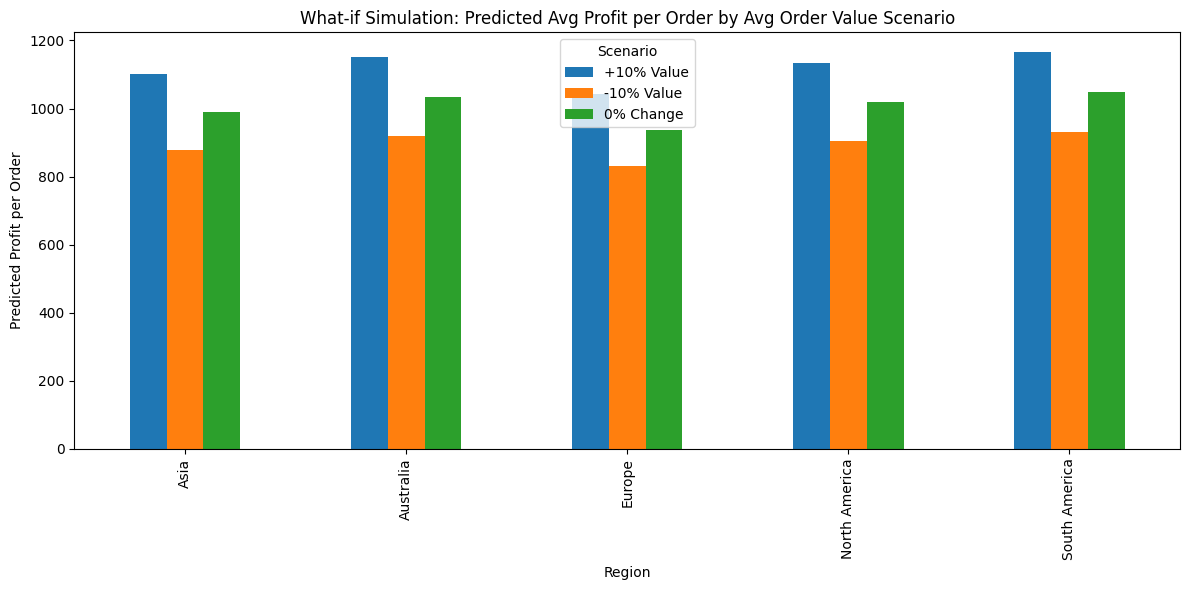

In [48]:
pivot_value.plot(kind='bar', figsize=(12,6), title='What-if Simulation: Predicted Avg Profit per Order by Avg Order Value Scenario')
plt.ylabel('Predicted Profit per Order')
plt.xlabel('Region')
plt.legend(title='Scenario')
plt.tight_layout()
plt.show()
